Homework 1

Name: Gautami Kant
Andrew ID: gkant

Extra Credit: PyTorch Implemention of a 2-layer neural network

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from typing import Optional, List, Tuple, Dict
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class DS(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray):
        self.length = len(X)
        self.X = X
        self.Y = Y

    def __getitem__(self, idx):
        x = self.X[idx, :]
        y = self.Y[idx]
        return (x, y)

    def __len__(self):
        return self.length

In [ ]:
# Parameters
indim = 10
outdim = 2
hidden_layer_1 = 100
hidden_layer_2 = 100
lr = 0.01
batch_size = 64
epochs = 200

In [ ]:
# Dataloader for training and test datasets

Xtrain = np.loadtxt("/content/drive/MyDrive/NN_HW1/XTrain.txt", delimiter="\t")
Ytrain = np.loadtxt("/content/drive/MyDrive/NN_HW1/yTrain.txt", delimiter="\t").astype(int)
Ytrain = torch.from_numpy(Ytrain)
Ytrain = Ytrain.type(torch.LongTensor)
m1, n1 = Xtrain.shape
print(m1, n1)
train_ds = DS(Xtrain, Ytrain)
train_loader = DataLoader(train_ds, batch_size=batch_size)

Xtest = np.loadtxt("/content/drive/MyDrive/NN_HW1/XTest.txt", delimiter="\t")
Ytest = np.loadtxt("/content/drive/MyDrive/NN_HW1/yTest.txt", delimiter="\t").astype(int)
Ytest = torch.from_numpy(Ytest)
Ytest = Ytest.type(torch.LongTensor)
m2, n2 = Xtest.shape
print(m2, n2)
test_ds = DS(Xtest, Ytest)
test_loader = DataLoader(test_ds, batch_size=batch_size)

500 10
200 10


In [ ]:
# Adding another hidden layer with 100 nodes

class SingleLayerMLP(nn.Module):
    """constructing a single layer neural network with Pytorch"""
    def __init__(self, indim, outdim, hidden_layer_1, hidden_layer_2):
        super(SingleLayerMLP, self).__init__()
        self.fc1 = nn.Linear(indim, hidden_layer_1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_layer_2, outdim)

    def forward(self, x):
        x = x.to(torch.float32)
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

In [ ]:
# Initialize the network

model = SingleLayerMLP(indim, outdim, hidden_layer_1, hidden_layer_2)
print(model)

SingleLayerMLP(
  (fc1): Linear(in_features=10, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=2, bias=True)
)


In [ ]:
# Initializing Loss and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr)

In [ ]:
# Constructing the training process

def training_process(train_loader, test_loader, model, loss_fn, num_epochs):

  train_size = len(train_loader.dataset)
  test_size = len(test_loader.dataset)
  num_batches_train = len(train_loader)
  num_batches_test = len(test_loader)

  # Initilizing training and test accuracy/loss which will be used for plotting
  train_loss = []
  test_loss = []
  train_acc = []
  test_acc = []
  epoch_id = []

  # Training loop
  train_temp = 0.0
  for epoch in range(epochs):
      loss_temp = 0.0
      for batch_idx, (X, y) in enumerate(train_loader):
          
          prediction = model(X)
          loss1 = loss_fn(prediction, y)
          
          #Reset the gradients of model parameters. Gradients add up by default so to prevent double-counting we explicitly zero them at each iteration
          optimizer.zero_grad()
          #Backpropagate the prediction loss 
          loss1.backward()
          #Adjust parameters obtained in the backward pass
          optimizer.step()
          
          loss_temp = loss_temp + loss1.item()
          train_temp += (prediction.argmax(1) == y).type(torch.float).sum().item()
          
      train_loss.append(loss_temp/num_batches_train)
      train_acc.append(train_temp/train_size)
      train_temp = 0.0

      # Test loop
      loss_testtemp = 0.0 
      correct_preds = 0
      with torch.no_grad():
            for X, y in test_loader:
              prediction = model(X)
              loss2 = loss_fn(prediction, y)
              loss_testtemp = loss_testtemp + loss2.item() 
              correct_preds += (prediction.argmax(1) == y).type(torch.float).sum().item()
      correct_preds /= test_size
      test_acc.append(correct_preds)
      test_loss.append(loss_testtemp/num_batches_test)
      epoch_id.append(epoch)

  return train_loss, test_loss, train_acc, test_acc, epoch_id

In [ ]:
# Calling the training function

train_loss, test_loss, train_acc, test_acc, epoch_id = training_process(train_loader, test_loader, model, loss_fn, epochs)

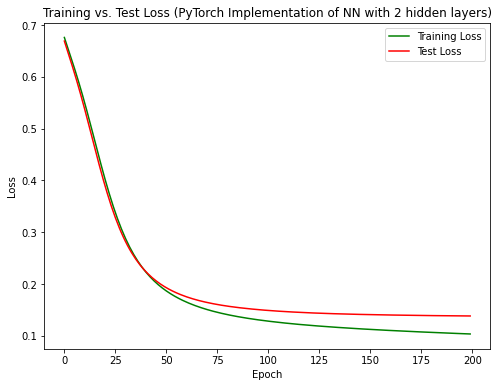

In [ ]:
## Plotting training and test loss

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(epoch_id, train_loss, color='green',label='Training Loss' )
ax.plot(epoch_id, test_loss, color='red', label = 'Test Loss' )
ax.set(title = "Training vs. Test Loss (PyTorch Implementation of NN with 2 hidden layers)",
       xlabel = "Epoch",
       ylabel = "Loss")
plt.legend()
plt.show()

In [ ]:
min_train_loss, min_test_loss = min(train_loss), min(test_loss)
min_train_loss, min_test_loss

(0.10353196039795876, 0.13828916661441326)

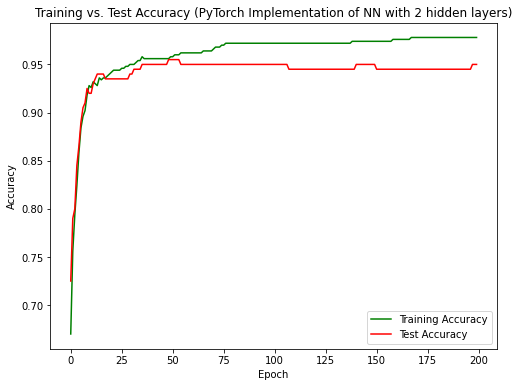

In [ ]:
## Plotting training and test accuracies

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(epoch_id, train_acc, color='green',label='Training Accuracy' )
ax.plot(epoch_id, test_acc, color='red', label = 'Test Accuracy' )
ax.set(title = "Training vs. Test Accuracy (PyTorch Implementation of NN with 2 hidden layers)",
       xlabel = "Epoch",
       ylabel = "Accuracy")
plt.legend()
plt.show()

In [ ]:
final_train_accuracy, final_test_accuracy = max(train_acc), max(test_acc)
final_train_accuracy, final_test_accuracy

(0.978, 0.955)

In [ ]:
min(train_acc), min(test_acc)

(0.67, 0.725)